# Vector Approach 
The intensity formula can be visualized as a vector inner product. We can take advantage of this representation to do some nifty sensitivity calculations!  
We can write the intensity at some pulsating-pigment concentration c1(Everything else remaining fixed), I1 as 
$$
I_1 = \sum_{i=1}^{N} G_i e^{-\epsilon c_1 L_i} = <G_i, e^{-\epsilon c_1 L_i}>
$$
where $G_i$ depends on all the non-pulsating components of the tissue and we want to cancel this term off the equation, N is the total number of photons at that point. Similarly for a second point, c2, we can write  
$$
I_2 = <G_i, e^{-\epsilon c_2 L_i}>
$$

The goal would be to figure out the sensitivity. Mathemetically speaking, how small of a $\Delta c = c_1 - c_2$ can we actually sense given some SNR for the intensity values.

## 1. Cosine
Both I1 and I2 can be written as
$$
I_1 = |G| |A| cos(\theta_a)
$$ 
$$
I_2 = |G| |B| cos(\theta_b)
$$
Where, A and B correspond to the exponential path terms related to c1 and c2 respectively. While, theta's are the angles between A or B and G. Based on this, if we took the log intensity difference,
$$
logI_1 - logI_2 = log (|A|) + log (|G|) + log (cos(\theta_a)) - log (|B|) - log (|G|) - log(cos(\theta_b)) = log (|A|) + log (cos(\theta_a)) - log (|B|) - log(cos(\theta_b))
$$
This trick takes log(|G|) from our equation. (But the actual value of G will still affect the angle $\angle GA = \theta_a$ and $\angle GB = \theta_b$). Focusing on the remaining terms,
$$
(log (|A|)  - log (|B|)) + (log (cos(\theta_a)) - log(cos(\theta_b)))
$$
How do these terms evolve and can we set of these pairs to 0? My intuition is that for small $\Delta c$, the angle should not change that much. Also note: $|A| = \sqrt{\sum_{i=1}^{N} e^{-2\epsilon c_1 L_i}}$ and $|B| = \sqrt{\sum_{i=1}^{N} e^{-2\epsilon c_2 L_i}}$. Which is essentially an integral dependent on the distribution of L. So, L gets transformed by the same exponential in both cases and then updated to some power and then integrated. 

__NOTE__ : The RAW data is collected for different number of detectors at each SDD. Keep this into consideration and divide by the detector count when comparing between different SDDs.

### Testing out the Inner Product against old calculations

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from inverse_modelling_tfo.tools.name_decoder import decode_extended_filename

# Pre-calculated intensity using the regular formula (inner product)
INTENSITY_DATA_PATH = Path('../data/s_based_intensity_low_conc2.pkl')

intensity_data = pd.read_pickle(INTENSITY_DATA_PATH)
RAW_SIM_DATA_PATH = '/home/rraiyan/simulations/tfo_sim/data/raw_dan_iccps_equispace_detector/fa_1_wv_1_sa_0.1_ns_1_ms_2_ut_5.pkl'
raw_sim_data = pd.read_pickle(RAW_SIM_DATA_PATH)
maternal_wall_thickness, uterus_thickness, wave_int = decode_extended_filename(RAW_SIM_DATA_PATH)
intensity_data = intensity_data[(intensity_data['Maternal Wall Thickness'] == maternal_wall_thickness) & (intensity_data['Wave Int'] == wave_int)]

In [29]:
intensity_data.groupby('Fetal Hb Concentration').groups.keys()

dict_keys([0.11, 0.125, 0.14, 0.15500000000000003, 0.17])

In [30]:
# Pick a certain setting
MATERNAL_Hb = 12.
MATERNAL_SAT = 0.9
FETAL_SAT = 0.225
FETAL_Hb = 0.11
c1 = intensity_data[(intensity_data["Maternal Hb Concentration"] == MATERNAL_Hb) & (intensity_data["Maternal Saturation"] == MATERNAL_SAT) & (intensity_data["Fetal Saturation"] == FETAL_SAT) & (intensity_data["Fetal Hb Concentration"] == FETAL_Hb)]

In [31]:
from inverse_modelling_tfo.tools.s_based_intensity_datagen import MU_MAP_BASE1, MU_MAP_BASE2, get_mu_a
# Create SDD column!
raw_sim_data['SDD'] = raw_sim_data['X'] - 100

In [32]:
# Mu Map
modified_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2
modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)
modified_mu_map[4] = get_mu_a(FETAL_SAT, FETAL_Hb, wave_int)

all_intensity = []
for sdd in c1["SDD"].to_numpy():
    filtered_photon_data = raw_sim_data[raw_sim_data['SDD'] == sdd]
    G = filtered_photon_data[['L1 ppath', 'L2 ppath', 'L3 ppath']].to_numpy()
    for i in range(1, 4):
        G[:, i - 1] = np.exp(-modified_mu_map[i] * G[:, i - 1])
    G = np.prod(G, axis=1)
    A = np.exp(-modified_mu_map[4] * filtered_photon_data['L4 ppath'].to_numpy())
    intensity = np.dot(A, G)
    all_intensity.append(intensity)

In [33]:
# Sanity Check
all_intensity = np.array(all_intensity)
# There is going to be some rounding-off error but otherwise the difference should be 0
print("Intensity Difference")
np.abs(all_intensity - c1['Intensity'].to_numpy())

Intensity Difference


array([9.31322575e-10, 5.82076609e-11, 1.45519152e-11, 1.45519152e-11,
       3.63797881e-12, 1.81898940e-12, 9.09494702e-13, 4.54747351e-13,
       2.27373675e-13, 1.13686838e-13, 0.00000000e+00, 0.00000000e+00,
       2.84217094e-14, 1.42108547e-14, 2.13162821e-14, 1.42108547e-14,
       3.55271368e-15, 3.55271368e-15, 1.77635684e-15, 0.00000000e+00])

### Testing Out the Log Intensity Difference Formula

In [34]:
MATERNAL_Hb = 12.
MATERNAL_SAT = 0.9
FETAL_SAT = 0.225
FETAL_Hb1 = 0.11
FETAL_Hb2 = 0.14

c1 = intensity_data[(intensity_data["Maternal Hb Concentration"] == MATERNAL_Hb) & (intensity_data["Maternal Saturation"] == MATERNAL_SAT) & (intensity_data["Fetal Saturation"] == FETAL_SAT) & (intensity_data["Fetal Hb Concentration"] == FETAL_Hb1)]
c2 = intensity_data[(intensity_data["Maternal Hb Concentration"] == MATERNAL_Hb) & (intensity_data["Maternal Saturation"] == MATERNAL_SAT) & (intensity_data["Fetal Saturation"] == FETAL_SAT) & (intensity_data["Fetal Hb Concentration"] == FETAL_Hb2)]
intensity_difference = np.log(c1['Intensity']).to_numpy() - np.log(c2['Intensity']).to_numpy()

In [35]:
# Mu Map
modified_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2
modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)
modified_mu_map['c1'] = get_mu_a(FETAL_SAT, FETAL_Hb1, wave_int)
modified_mu_map['c2'] = get_mu_a(FETAL_SAT, FETAL_Hb2, wave_int)
all_A = []
all_B = []
all_G = []
all_cos_a = []
all_cos_b = []
all_aprrox1 = []
all_aprrox2 = []
all_L4 = []

int_diffs = []
for sdd in c1["SDD"].to_numpy():
    filtered_photon_data = raw_sim_data[raw_sim_data['SDD'] == sdd]
    G = filtered_photon_data[['L1 ppath', 'L2 ppath', 'L3 ppath']].to_numpy()
    for i in range(1, 4):
        G[:, i - 1] = np.exp(-modified_mu_map[i] * G[:, i - 1])
    G = np.prod(G, axis=1)
    L4 = filtered_photon_data['L4 ppath'].to_numpy()
    A = np.exp(-modified_mu_map['c1'] * L4)
    B = np.exp(-modified_mu_map['c2'] * L4)
    cos_a = np.dot(A, G) / np.linalg.norm(A) / np.linalg.norm(G)
    cos_b = np.dot(B, G) / np.linalg.norm(B) / np.linalg.norm(G)
    int_diff = np.log(np.linalg.norm(A) * cos_a / np.linalg.norm(B) / cos_b)
    approx1 = np.log(cos_a / cos_b)
    approx2 = np.log(np.linalg.norm(A) / np.linalg.norm(B))
    
    all_G.append(G)
    all_L4.append(L4)
    all_A.append(A)
    all_B.append(B)
    all_cos_a.append(cos_a)
    all_cos_b.append(cos_b)
    int_diffs.append(int_diff)
    all_aprrox1.append(approx1)
    all_aprrox2.append(approx2)

int_diffs = np.array(int_diffs)
all_aprrox1 = np.array(all_aprrox1)
all_aprrox2 = np.array(all_aprrox2)

In [36]:
intensity_diff_error_df = pd.DataFrame({
    'SDD': c1['SDD'].to_numpy(),
    'No Approx' : np.abs(int_diffs - intensity_difference),
    'Approx 1 (Only cosines)': np.abs(all_aprrox1 - intensity_difference),
    'Approx 2 (Only norms)' : np.abs(all_aprrox2 - intensity_difference)
})
print("Aboslute Log Error")
display(intensity_diff_error_df)

Aboslute Log Error


,SDD,No Approx,Approx 1 (Only cosines),Approx 2 (Only norms)
0,10,1.762045e-15,0.007515,0.004375
1,14,3.400058e-16,0.021160,0.003662
2,19,1.436351e-15,0.040175,0.019583
3,23,5.134781e-16,0.058069,0.034379
4,28,1.318390e-15,0.074120,0.047839
5,32,1.110223e-15,0.087176,0.059205
6,37,5.551115e-17,0.097968,0.069483
7,41,2.775558e-17,0.105741,0.077207
8,46,2.775558e-16,0.111004,0.082514
9,50,3.053113e-16,0.114474,0.087007


In [37]:
angles_df = pd.DataFrame({
    "Cos(Theta_a)" : all_cos_a,
    "Cos(Theta_b)" : all_cos_b,
})
display(angles_df)

,Cos(Theta_a),Cos(Theta_b)
0,0.509285,0.511517
1,0.537600,0.535634
2,0.466614,0.457565
3,0.404312,0.390648
4,0.350647,0.334267
5,0.303756,0.286294
6,0.259462,0.242046
7,0.223829,0.207198
8,0.191498,0.176331
9,0.163382,0.149767


__Remarks__ : Unfortunately, both the norm and the angle term affect the final result. i.e., my assumption that one of those two pairs' difference is close to 0 was not correct. Also, the very small error show in the No Approx is rounding error. Too small to actually care about. 

In [38]:
from ipywidgets import interact
import ipywidgets as widgets

In [39]:
def plot_vector_dist(sdd_index):
    plt.figure(figsize=(16,8))
    plt.suptitle("Distribution of the Elements of the Vectors")
    plt.subplot(121)
    plt.hist(all_L4[sdd_index], 150, label='L', alpha=0.5)
    plt.legend()
    plt.subplot(122)
    plt.hist(all_A[sdd_index], 150, label='A', alpha=0.5)
    plt.hist(all_B[sdd_index], 150, label='B', alpha=0.5)
    plt.legend()

interact(plot_vector_dist, sdd_index=widgets.IntSlider(4, min=0, max=19, step=1))



interactive(children=(IntSlider(value=4, description='sdd_index', max=19), Output()), _dom_classes=('widget-in…

<function __main__.plot_vector_dist(sdd_index)>

In [40]:
# plt.figure(figsize=(10, 4))
# img = np.zeros((len(all_A), len(all_A[0])))
# for i, current_A in enumerate(all_A):
#     img[i, :len(current_A)]  = current_A
# plt.imshow(img, aspect='auto')
# plt.colorbar()
# plt.show()

## Exploring the effect of c on the distribution of exp(-cL)
Given some distirubtion of L, how does the distribution of exp(-cL) change with changes in c. More importantly how do the sums tranform? This would help us in determining the term $log(|A|) - log(|B|) $ from above. Which can be further simplified into
$$
log(|A|) - log(|B|) = \frac{1}{2}log(\frac{\sum exp(-2\epsilon c_1 L_i)}{\sum exp(-2\epsilon c_2 L_i)})
$$
This can be further modified to get a more succint result. But we need to start from a bit earlier. Let's say we have the distribution count for L and we call it N(L). As in, given some L, D(L) will give you how many $L_i$'s have that specific value. Think of a an unnormalized distribution. Given this, we can calculate the $\sum L$ as $\int_0^{\inf} D(L) L dL $. We can use a similar formulation for each of the terms here. Before we can do that though, we need to convert change the variable $exp(-2\epsilon c L)$ to make the integration easier. Say
$$
exp(-2\epsilon c L) = u
$$
then
$$
-2 \epsilon c e^{-2\epsilon c L} dL = du
$$
and
$$
L = \frac{ln (u)}{-2\epsilon c}
$$
so, we can write the sum as
$$
\sum exp(-2\epsilon c L) \approx \int_{0}^{\inf} D(L) e^{-2\epsilon c L} dL = \frac{1}{-2 \epsilon c}\int_{0}^{\inf} D(\frac{ln (u)}{-2\epsilon c}) du = \frac{1}{2 \epsilon c} N
$$
From here I am hoping the negative sign inside N and the negative sign outisde would cancel each other out because the plots always show positive results. But the integral eventually resolves to the total photon count, N. Replacing this result back into the original log(A) - log(B),
$$
log(|A|) - log(|B|) = \frac{1}{2}log(\frac{c_2}{c_1})
$$

This can be justified using the plot for $log|A|$ vs c, for a range of values of c. We see a log-log linear relationship. 

__NOTE__: One thing that still confuses me is the case for when $c=0$. From the equations, it should not be defined. Yet due to some weird asymtotic behaviour, it has a well defined value at N(or the number of photons received on that detector)

In [41]:
# def plot_c_dist(c):
#     epsilon = get_mu_a(FETAL_SAT, FETAL_Hb1, wave_int) / FETAL_Hb1 
#     L_INDEX = 10
#     L = all_L4[L_INDEX]
#     plt.figure(figsize=(16,8))
#     plt.suptitle("Distribution of L and exp(-cL)")
#     plt.subplot(121)
#     plt.hist(L, 150, label='L', alpha=0.5)
#     plt.legend()
#     plt.subplot(122)
#     transformed_L = np.exp(-2 * epsilon * c * L)
#     plt.hist(transformed_L, 150, label='A', alpha=0.5)
#     plt.legend()
#     print("L sum", np.sum(L))
#     print("exp(-cL) sum", np.sum(transformed_L))

# interact(plot_c_dist, c=widgets.FloatSlider(0.1, min=0, max=1, step=0.01))

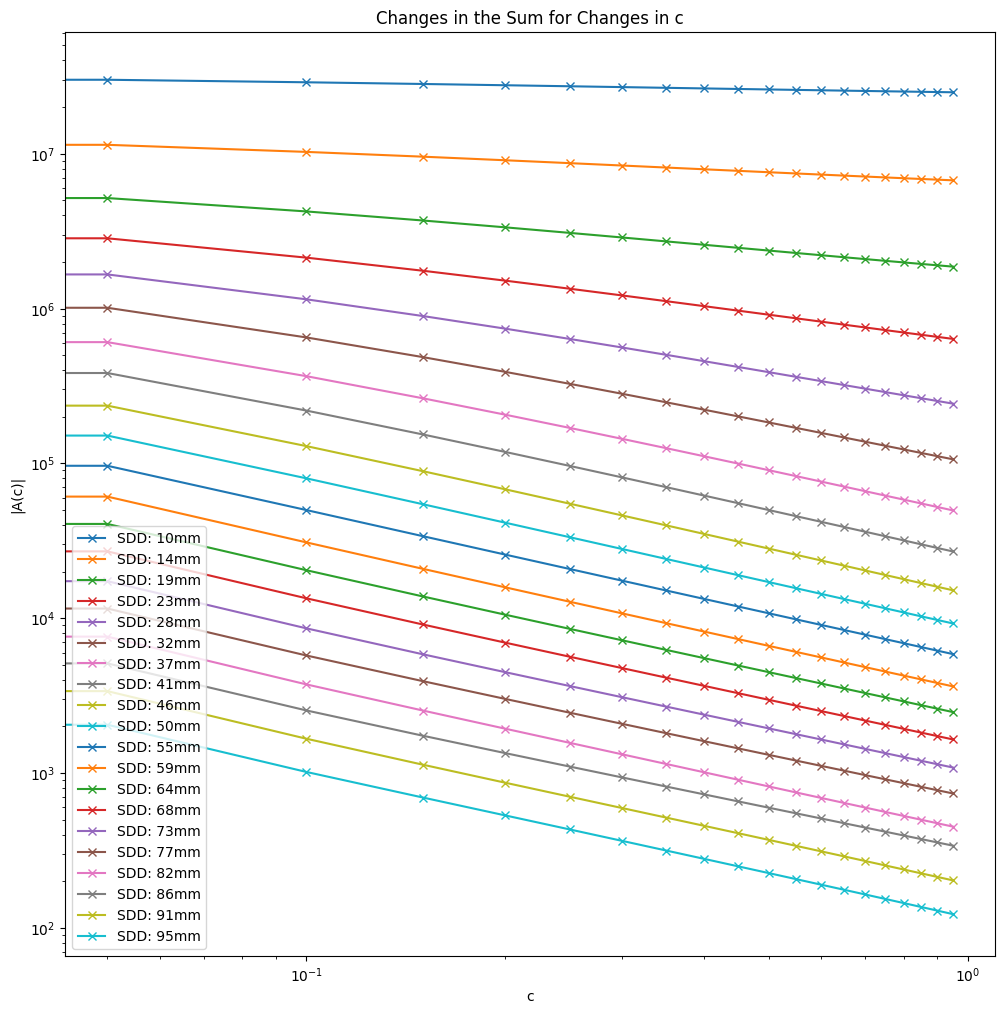

In [42]:
plt.figure(figsize=(12, 12))
plt.title("Changes in the Sum for Changes in c")
for L_INDEX in range(20):
    exp_L_sum = []
    L = all_L4[L_INDEX]
    # same trends for both ranges
    all_c = np.arange(0, 1, 0.05)
    # all_c = np.arange(0, 10, 0.5)

    for c in all_c:
        epsilon = get_mu_a(FETAL_SAT, FETAL_Hb1, wave_int) / FETAL_Hb1 
        transformed_L = np.exp(-2 * epsilon * c * L)
        exp_L_sum.append(np.sum(transformed_L))

# print("L sum", np.sum(L))
    plt.plot(all_c, exp_L_sum, 'x-', label=f"SDD: {c1['SDD'].to_list()[L_INDEX]}mm")
plt.xlabel('c')
# plt.ylabel('$\sum exp(-2\epsilon c L_i)$')
plt.ylabel('|A(c)|')
plt.yscale('log')
plt.xscale('log')
plt.legend()

__Remark__ : Alothough I could not find a solid relation between L and exp(-cL) analytically, there does seem to be some relation log-log linear relation from the plots. This could be an effect of the type of distribution I am working with? Regardless, here are the key takeaways
1. $\sum L$ and $\sum exp(-2c\epsilon L)$ are related in a log-log linear manner. As in if we took the log of both c and L, the plot would be linnear. 
2. At $c=0$, the equation essentially gives the photon count (Or number of elements in L). If we had the information for another aribitrary point, we can recreate the line and fit any other arbitrary point
3. From the plots at different SDD, its apparent near detectors are not very sensitive. While, far detectors are pretty sensitive to changes in the fetal layer (At least in the log sense). Example: Look at the deep blue line at the top. It shifts for changes in c. Whereas, the teal curve at the very bottom shows the largest gradient for changes in c.
4. These plots can be used to determine the sensitivity of our Log Difference to $\Delta c$. Pick a line(color). Pick any two c on that line. The vertical difference between them is our $log|A| - log|B|$. (One of the 2 terms in the Log Difference, the more dominant one. To be super mathemetically acuurate, the $log|A| - log|B|$ would actually be 1/2 of the vertical distance).
5. One thing that's clear from this part is that the senstivity is dependent on the actual values of $c_1$ and $c_2$ rather than just their difference. The c values here are equidistance in a linear scale sense but in the log sense the distance is different. But since the plots are log-log linear, we see that for a smaller c, the vertical drop is much higher for a slight change. Whereas, for the larger c's, the vertical drop is relatively smaller for similar ammounts of change. At least for this $log|A| - log|B|$ term. Need to determine how the other cosine term behaves.
6. If you look at the entire equation, we are essentially adding and then subtracting the same term. The log|A| - log|B| term also exists inside the cosine difference term, which would cancel out this term. It would make more senes if there was some way to calculate the cosine without using the dot product/norms or if the cosine difference term was negligible. (Which somehow is the case for far detectors!)

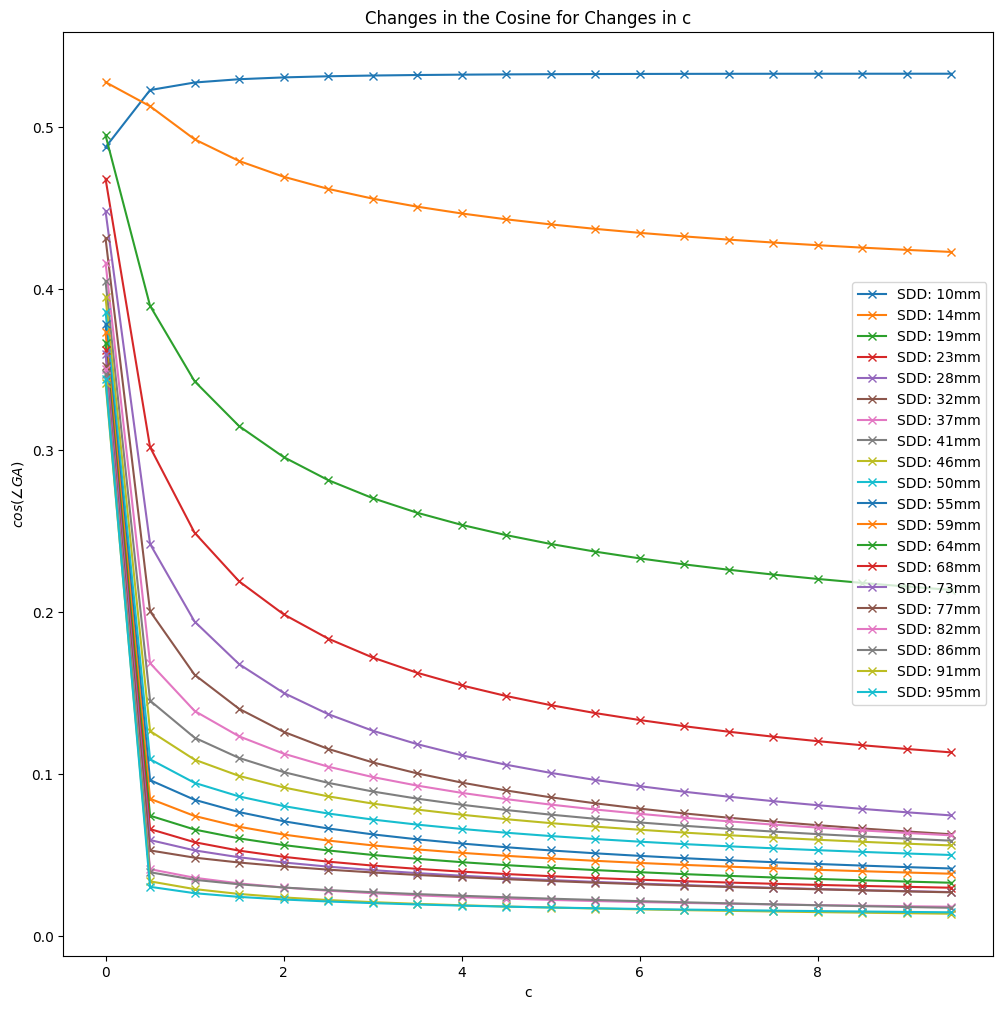

In [47]:
plt.figure(figsize=(12, 12))
plt.title("Changes in the Cosine for Changes in c")
for L_INDEX in range(20):
    all_cos_theta = []
    L = all_L4[L_INDEX]
    # same trends for both ranges
    # all_c = np.arange(0, 1, 0.05)
    all_c = np.arange(0, 10, 0.5)

    for c in all_c:
        epsilon = get_mu_a(FETAL_SAT, FETAL_Hb1, wave_int) / FETAL_Hb1 
        transformed_L = np.exp(- epsilon * c * L)
        cos_theta = np.dot(all_G[L_INDEX], transformed_L) / np.linalg.norm(all_G[L_INDEX]) / np.linalg.norm(transformed_L)
        # all_cos_theta.append(np.arccos(cos_theta))
        all_cos_theta.append(cos_theta)

    plt.plot(all_c, all_cos_theta, 'x-', label=f"SDD: {c1['SDD'].to_list()[L_INDEX]}mm")
plt.xlabel('c')
# plt.ylabel(r'$cos(\theta)$')
plt.ylabel(r'$cos(\angle GA)$')
# plt.yscale('log')
# plt.xscale('log')
plt.legend()

__Remark__ : There definitely seems to be some sort of a pattern within the cosine terms with c. But is this something that relies on the tissue model itself or is there something more generic? I plotted the theta and it looks like they start around 1rad and slowly increase with c. The change for the far detectors is very small. However, there does seem to a patter between them

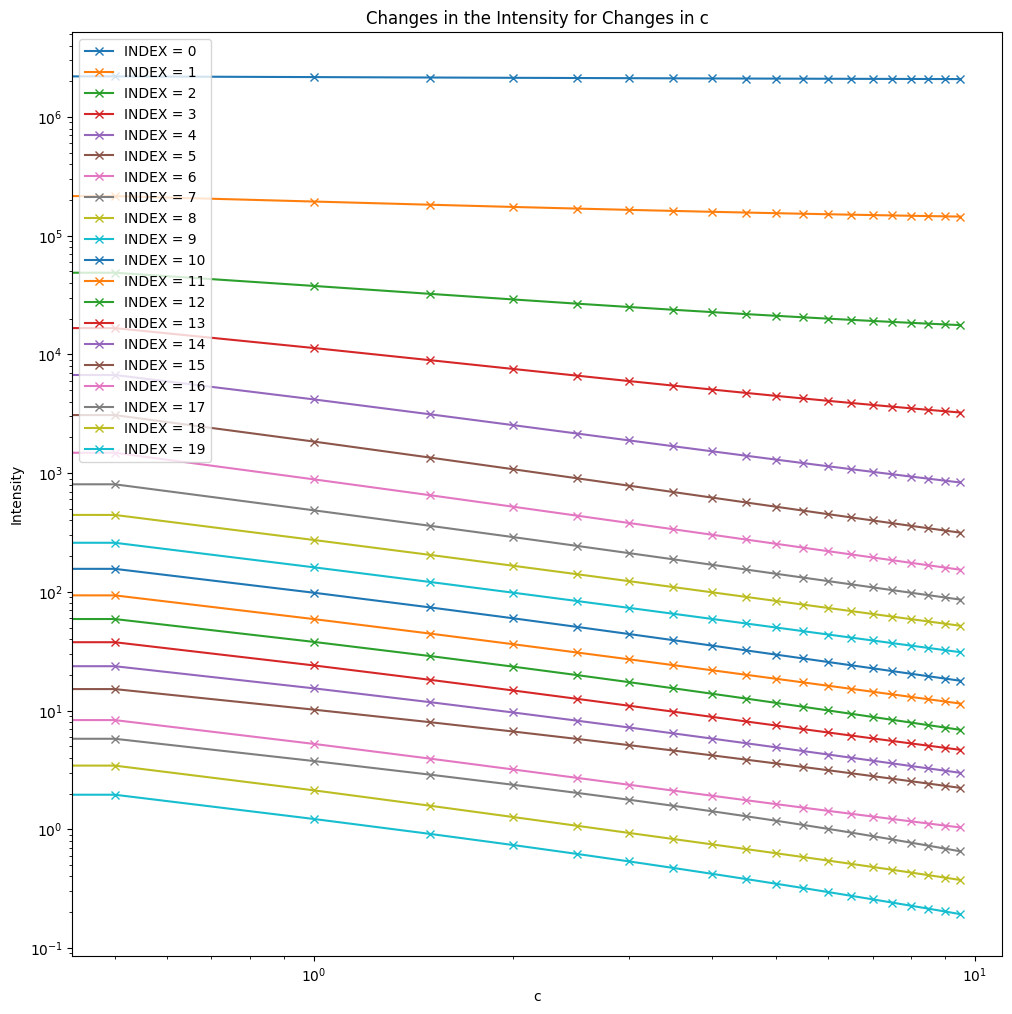

In [44]:
# Intensity Plot
# Directly calculate intensity, analogous to what is happening on the above cells
epsilon = get_mu_a(FETAL_SAT, FETAL_Hb1, wave_int) / FETAL_Hb1 
plt.figure(figsize=(12, 12))
plt.title("Changes in the Intensity for Changes in c")
for L_INDEX in range(20):
    all_intensity = []
    L = all_L4[L_INDEX]
    G = all_G[L_INDEX]
    # same trends for both ranges
    # all_c = np.arange(0, 1, 0.05)
    all_c = np.arange(0, 10, 0.5)

    for c in all_c:
        transformed_L = np.exp(- epsilon * c * L)
        all_intensity.append(np.dot(transformed_L, G))

# print("L sum", np.sum(L))
    plt.plot(all_c, all_intensity, 'x-', label=f'INDEX = {L_INDEX}')
plt.xlabel('c')
plt.ylabel('Intensity')
plt.yscale('log')
plt.xscale('log')
plt.legend()


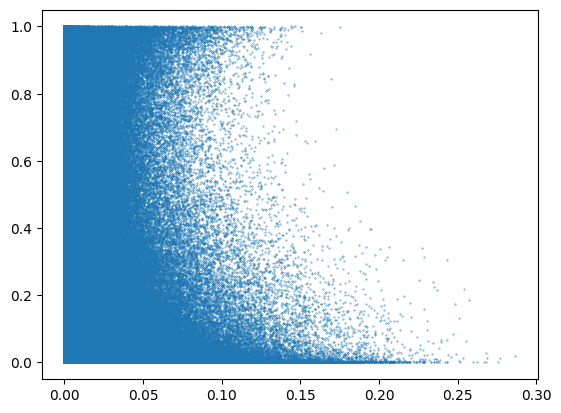

In [45]:
# # this plot takes a whil
plt.figure()
plt.scatter(all_G[7], all_A[7], s=0.1)

__Remark__ : I was trying to see if there is any sort of relation between $G_i$ and $A_i$. Well, its pretty uniformly distributed. So there really isn't an easy way to replace the inner product with some distribution based equations 

## Figuring Out How the Cosine Changes with C
### Angle with Unit45
The exact angle between G and A is hard to determine analytically and will obviously depend on the tissue model used. However, we can use a proxy. Let's assume there is some vector at 45 degree angle in the same dimentionality as both G and A, with all the elements of this vector being 1. We can think of it as, G remaining fixed while A slowly changes with the change in c. As long as G and A reside on the same side of this vector unit45 vector, the angle between unit45 and A will mimic the angle between G and A. (imagine $\angle GA = \phi + \angle A Unit45$, where $phi$ is some constant and will depend on the exact tissue model being used). If at some point A flips sides, we should see a change in trends. With that in mind, lets look at the cosine between Unit45 and A. We call it $\theta'$ for this discussion to avoid consfusion. From our regular dot product rule we get,
$$
cos(\theta') = \frac{<A, Unit45>}{|A||Unit45|} = \frac{\sum exp(-c\epsilon L_i) \times 1}{\sqrt{\sum exp(-2c\epsilon L_i)} \times \sqrt{N}}
$$
Where, again N is the number of dimensions or in this case the number of photons detected. Both these sum terms can be solved the same way as [Here](#exploring-the-effect-of-c-on-the-distribution-of-exp-cl) . Giving us,
$$
cos(\theta') = \frac{\frac{N}{\epsilon c}}{\sqrt{\frac{N}{2\epsilon c}} \times \sqrt{N}} = \frac{\sqrt{2}}{\sqrt{\epsilon c}}
$$

THe cosine is inversely proportional to the square root of c. This actually explain why the cosine decreases with c and the decrease stagnates for larger values of c and changes a lot for smaller values of c. Also, for this set of plots, there is different trend for the blue curve. Which might be where the sides flip. (The cosine collapses to 0 for c=0)

/tmp/ipykernel_2392809/1502520142.py:16: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(cos_theta)


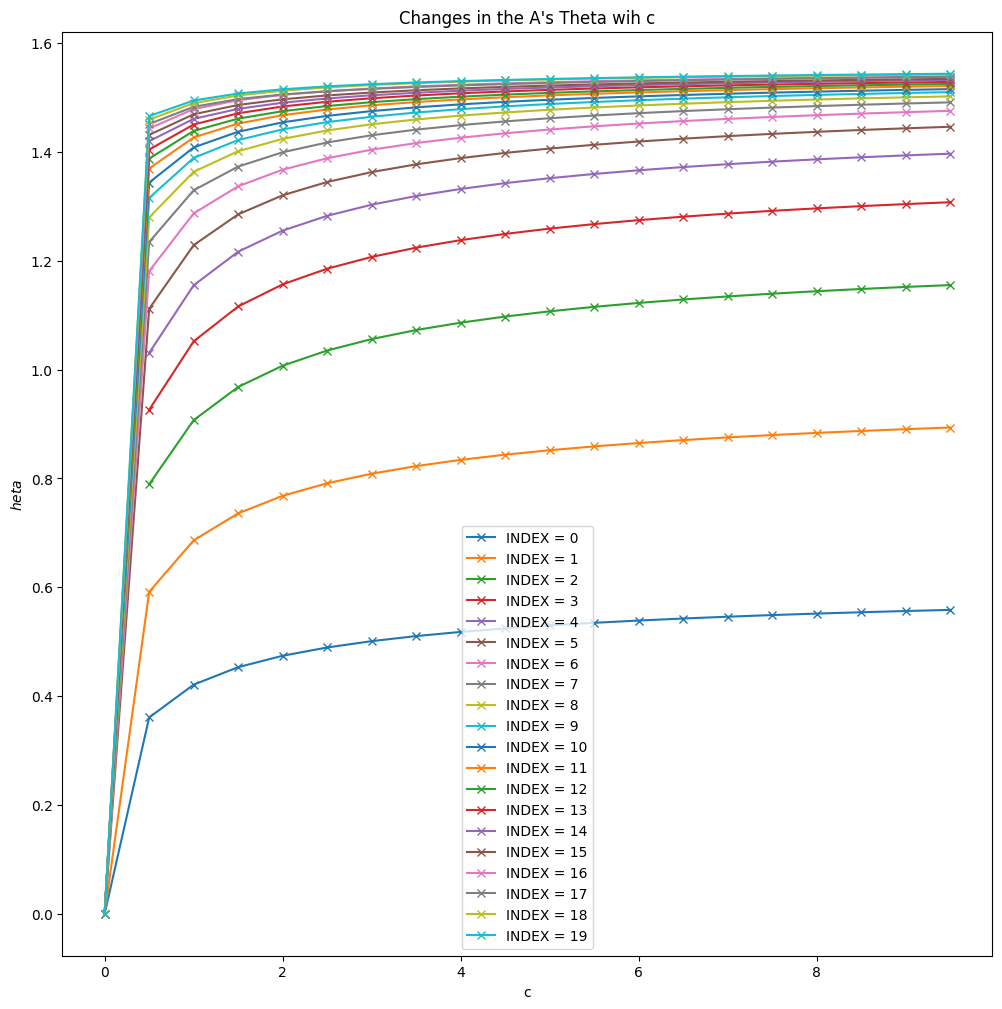

In [46]:
plt.figure(figsize=(12, 12))
plt.title("Changes in the A's Theta wih c")
for L_INDEX in range(20):
    all_theta = []
    L = all_L4[L_INDEX]
    # same trends for both ranges
    # all_c = np.arange(0, 1, 0.05)
    all_c = np.arange(0, 10, 0.5)

    for c in all_c:
        # epsilon = get_mu_a(FETAL_SAT, FETAL_Hb1, wave_int) / FETAL_Hb1 
        transformed_L = np.exp(- epsilon * c * L)
        unit_45 = np.ones_like(transformed_L)
        cos_theta = np.dot(unit_45, transformed_L) / np.linalg.norm(unit_45) / np.linalg.norm(transformed_L)
        # all_cos_theta.append(np.arccos(cos_theta))
        theta = np.arccos(cos_theta)
        all_theta.append(theta)

    plt.plot(all_c, all_theta, 'x-', label=f'INDEX = {L_INDEX}')
plt.xlabel('c')
plt.ylabel('$ \theta $')
# plt.yscale('log')
# plt.xscale('log')
plt.legend()

__Remark__ : At c=0. L is the same as unit45 (Since all elements inside L essentially turn into 1.) Which is why the cosine is also 0. 